# Comparison between different models and datasets

### Imports and Parameters

In [1]:
# External libraries
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Make all files in the repository accessible
import path
import sys
repo_directory = path.package_directory + "/.."
sys.path.append(repo_directory)

In [5]:
# Own modules
import reference_code.mnist_minimal_example.model as og_model
from modules.model import Rotated_cINN

from reference_code.mnist_minimal_example.data import train_data as og_train
from reference_code.mnist_minimal_example.data import unnormalize as og_unnormalize
from modules.data import RotatedMNIST

In [6]:
# Parameters
device = 'cuda'  if torch.cuda.is_available() else  'cpu'
random_seed = 1

### Loading Models and Datasets

#### Definitions

In [7]:
def load_model(name:str):
    model_path = path.package_directory + f"/trained_models/{name}.pt"
    model = Rotated_cINN().to(device)
    state_dict = {k:v for k,v in torch.load(model_path).items() if 'tmp_var' not in k}
    model.load_state_dict(state_dict)
    model.eval()

    return model 


class CinnMnist(Dataset):
    def __init__(self, data, labels) -> None:
        super().__init__()
        self.data = data
        self.targets = labels

    def __getitem__(self, index):
        return self.data[index], self.targets[index]
    
    def __len__(self):
        return len(self.targets)

#### Models

In [8]:

# original cINN model
model_path = repo_directory + '/reference_code/mnist_minimal_example/output/mnist_cinn.pt'
og_cinn = og_model.MNIST_cINN(0).to(device)
og_cinn.to(device)
state_dict = {k:v for k,v in torch.load(model_path).items() if 'tmp_var' not in k}
og_cinn.load_state_dict(state_dict)
og_cinn.eval();


# different Rotated cINN models
oned_cinn = load_model("sanity_check_one_domain")
norm_cinn = load_model("normalized_data")
aug_one_cinn = load_model("augmented_one_domain")
augm_cinn = load_model("augmented_multi_domain")
laug_cinn = load_model("lazy_augmentation")



#### Datasets

In [9]:
def mini_test(data, name):
    print(name)
    print(f"type: {type(data)}")
    if type(data) == torch.Tensor:
        print(f"size: {data.shape}, dtype: {data.dtype}")
        print(f"min: {data.min():.4f}, max: {data.max():.4f}")
        if data.dtype == torch.float:
            print(f"median: {np.median(data):.4f}")
            print(f"mean: {data.mean():.4f}, std: {data.std():.4f}")
    print("")

In [10]:
# raw MNIST
data_directory = path.package_directory + "/data"
torch.manual_seed(random_seed)

mnist = datasets.MNIST(data_directory, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), lambda x: (x - 0.128) / 0.305]))
mini_test(mnist.data, "mnist_tf_norm")

val_x, val_l = zip(*list(mnist[i] for i in range(1024)))
val_x = torch.stack(val_x, 0).to(device)
val_l = torch.LongTensor(val_l).to(device)
og_val = CinnMnist(val_x, val_l)
mini_test(og_val.data, "og_val")

mnist.data = mnist.data[1024:]
mnist.targets = mnist.targets[1024:]
mini_test(mnist.data, "mnist_wo_val")

mnist.transform = transforms.Compose([mnist.transform, lambda x: x + 0.08 * torch.randn_like(x)])
mini_test(mnist.data, "mnist_tf_augm")


loader = DataLoader(mnist, batch_size=len(mnist.targets), shuffle=True)
images, labels = next(iter(loader))
images = images.squeeze(1)   # remove the batch dimension

mnist_data = CinnMnist(images, labels)
mini_test(mnist_data.data, "mnist_loader")


# original cINN MNIST - normalized and augmented
torch.manual_seed(random_seed)
mini_test(og_train.data, "og_cinn_dataset")
loader = DataLoader(og_train, batch_size=len(og_train.targets), shuffle=True)
images, labels = next(iter(loader))
images = images.squeeze(1)   # remove the batch dimension
og_data = CinnMnist(images, labels)
mini_test(og_data.data, "og_cinn_loader")

mnist_tf_norm
type: <class 'torch.Tensor'>
size: torch.Size([60000, 28, 28]), dtype: torch.uint8
min: 0.0000, max: 255.0000

og_val
type: <class 'torch.Tensor'>
size: torch.Size([1024, 1, 28, 28]), dtype: torch.float32
min: -0.4197, max: 2.8590
median: -0.4197
mean: -0.0004, std: 0.9992

mnist_wo_val
type: <class 'torch.Tensor'>
size: torch.Size([58976, 28, 28]), dtype: torch.uint8
min: 0.0000, max: 255.0000

mnist_tf_augm
type: <class 'torch.Tensor'>
size: torch.Size([58976, 28, 28]), dtype: torch.uint8
min: 0.0000, max: 255.0000

mnist_loader
type: <class 'torch.Tensor'>
size: torch.Size([58976, 28, 28]), dtype: torch.float32
min: -0.8510, max: 3.2355
median: -0.3962
mean: 0.0089, std: 1.0136

og_cinn_dataset
type: <class 'torch.Tensor'>
size: torch.Size([58976, 28, 28]), dtype: torch.uint8
min: 0.0000, max: 255.0000

og_cinn_loader
type: <class 'torch.Tensor'>
size: torch.Size([58976, 28, 28]), dtype: torch.float32
min: -0.8510, max: 3.2355
median: -0.3962
mean: 0.0089, std: 1.0136


In [11]:
# Rotated MNIST - one domain (0° like MNIST)
domains = [0]
oned_data = RotatedMNIST(domains=domains, train=True, seed=random_seed, val_set_size=1000)


# Rotated MNIST - multiple domains, normalized
domains = [-23, 0, 23, 45, 90, 180]
norm_data = RotatedMNIST(domains=domains, train=True, seed=random_seed, val_set_size=1000, normalize=True)


# Rotated MNIST - one domain, normalized and augmented
domains = [0]
augm_data = RotatedMNIST(domains=domains, train=True, seed=random_seed, val_set_size=1000, normalize=True, add_noise=True)


# Rotated MNIST - one domain, lazy augmentation
domains = [0]
laug_data = RotatedMNIST(domains=domains, train=True, seed=random_seed, val_set_size=1000, normalize=True, add_noise=False)
laug_data.transform = transforms.Lambda(lambda data: data + laug_data.noise_std * torch.randn_like(data))   # Add new noise to each new batch 


## Tests and comparisons

### Dataset comparisons

In [12]:
# Definitions

def run_data_test(data: np.ndarray, name=""):
    print(f"\n{name}")
    print(f"min: {data.min():.4f}, median: {np.median(data):.4f}, max: {data.max():.4f}")
    print(f"mean: {data.mean():.4f}, std: {data.std():.4f}")
    
    fraction_above_one = np.count_nonzero(data > 1) / len(data.flatten())
    fraction_below_zero = np.count_nonzero(data < 0) / len(data.flatten())
    fraction_in_range = 1 - fraction_above_one - fraction_below_zero
    percent = lambda x: f"{100*x:.2f} %"
    print(f"x<0:{percent(fraction_below_zero)}, 0<=x<=1: {percent(fraction_in_range)}, x>1:{percent(fraction_above_one)}")


    hist_range = (-3, 3)
    flat_data = data.flatten()
    clipped_data = np.clip(flat_data, *hist_range)
    plt.figure(figsize=(6, 3))
    plt.hist(clipped_data, bins=1000, range=hist_range, density=True)
    plt.yscale('log')
    plt.ylim(10**-2, 2*10**1)
    plt.show()

In [13]:
# Rotated MNIST - one domain, lazy augmentation
domains = [0]
noise_augmentation = lambda data: data + 0.08 * torch.randn_like(data)
laug_data = RotatedMNIST(domains=domains, train=True, seed=random_seed, val_set_size=1000, normalize=True, add_noise=False, transform = transforms.Lambda(noise_augmentation))

In [14]:
sample = laug_data[1]
print(type(sample))
print(sample[0].shape, sample[1].shape)
print("")

sample = laug_data[1:10]
print(type(sample))
print(sample[0].shape, sample[1].shape)
print("")

sample = laug_data[:]
print(type(sample))
print(sample[0].shape, sample[1].shape)
print("")

<class 'tuple'>
torch.Size([28, 28]) torch.Size([12])

<class 'tuple'>
torch.Size([9, 28, 28]) torch.Size([9, 12])

<class 'tuple'>
torch.Size([59000, 28, 28]) torch.Size([59000, 12])



In [15]:
laug_data.transform(torch.ones(10))

tensor([0.8796, 1.0131, 0.9361, 0.8991, 1.1126, 1.0438, 0.9372, 0.9088, 1.0031,
        1.0077])

#### Comparing the dataset pixel value distributions

In [16]:
# Loading the dataset images
mnist_train_data = mnist_data.data.cpu().numpy()
og_train_data = og_data.data.cpu().numpy()
oned_train_data = oned_data.data.cpu().numpy()
norm_train_data = norm_data.data.cpu().numpy()
augm_train_data = augm_data.data.cpu().numpy()
laug_train_data = laug_data[:][0].cpu().numpy()  # samples all images and applies tranforms


Original cINN train data
min: -0.8510, median: -0.3962, max: 3.2355
mean: 0.0089, std: 1.0136
x<0:82.95 %, 0<=x<=1: 3.20 %, x>1:13.85 %


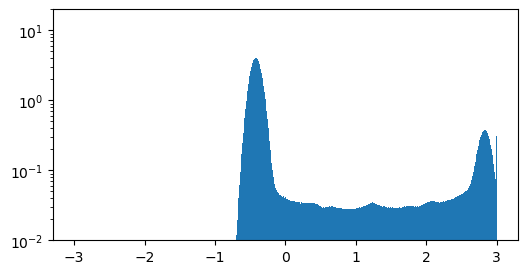


Lazy augmented train data
min: -0.8750, median: -0.4006, max: 3.2159
mean: -0.0002, std: 1.0028
x<0:83.00 %, 0<=x<=1: 3.22 %, x>1:13.79 %


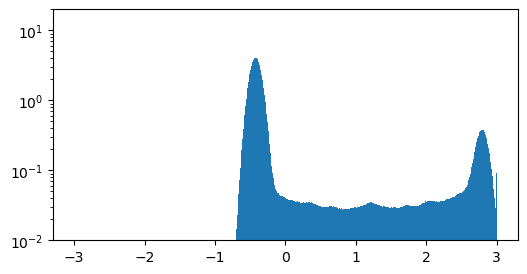


Augmented train data
min: -0.8554, median: -0.4006, max: 3.2194
mean: -0.0002, std: 1.0028
x<0:83.00 %, 0<=x<=1: 3.22 %, x>1:13.79 %


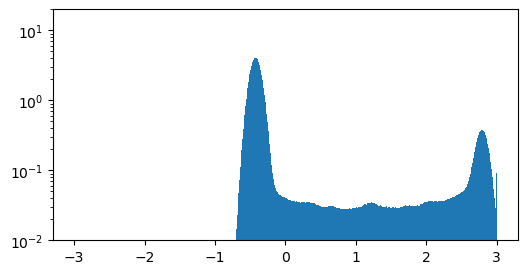


Normalized train data
min: -0.4241, median: -0.4241, max: 2.8206
mean: -0.0002, std: 0.9697
x<0:81.87 %, 0<=x<=1: 4.25 %, x>1:13.88 %


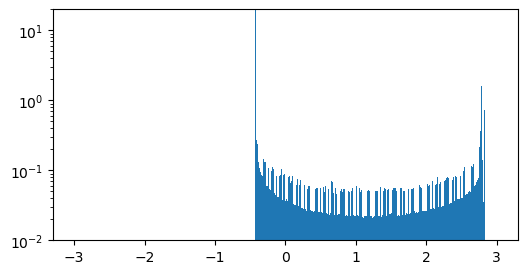


One Domain train data
min: 0.0000, median: 0.0000, max: 1.0000
mean: 0.1306, std: 0.3081
x<0:0.00 %, 0<=x<=1: 100.00 %, x>1:0.00 %


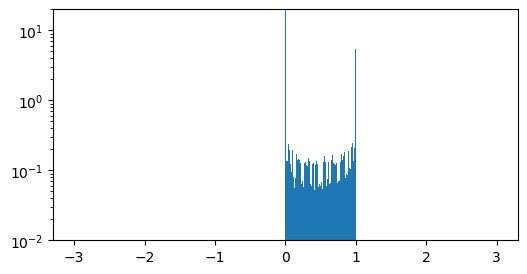

In [17]:
#run_data_test(mnist_train_data, "raw MNIST train data")
run_data_test(og_train_data, "Original cINN train data")
run_data_test(laug_train_data, "Lazy augmented train data")
run_data_test(augm_train_data, "Augmented train data")
run_data_test(norm_train_data, "Normalized train data")
run_data_test(oned_train_data, "One Domain train data")

### Model comparisons

#### Sampling images

In [20]:
# Parameters

sample_shape = (10000,)
latent_tensor = torch.randn((*sample_shape, 28*28))
labels = torch.randint(0, 10, sample_shape)

In [21]:
# Definitions

def rotated_conditions(domains):
    domain_labels = torch.randint(0, len(domains), sample_shape)
    conditions = torch.zeros((*sample_shape, 12))
    conditions[..., :2] = RotatedMNIST.deg2cossin(domain_labels)
    conditions[..., 2:] = torch.eye(10)[labels]

    return conditions


def sample_images(model:Rotated_cINN, dataset:RotatedMNIST) -> np.ndarray:
    conditions = rotated_conditions(dataset.domains)
    model_images = model.reverse(latent_tensor, conditions)[0].cpu().numpy()
    images = dataset.unnormalize(model_images)
    
    return images

In [22]:
# Sample images for each model

with torch.no_grad():
    og_images = og_cinn.reverse_sample(latent_tensor, labels)[0].cpu().numpy()
    og_images = og_unnormalize(og_images)
    oned_images = sample_images(oned_cinn, oned_data)
    norm_images = sample_images(norm_cinn, norm_data)
    aug_one_images = sample_images(aug_one_cinn, augm_data)
    augm_images = sample_images(augm_cinn, augm_data)
    laug_images = sample_images(laug_cinn, laug_data)


Lazy augmented train data
min: -0.1390, median: 0.0072, max: 1.1218
mean: 0.1306, std: 0.3091
x<0:40.60 %, 0<=x<=1: 56.53 %, x>1:2.87 %


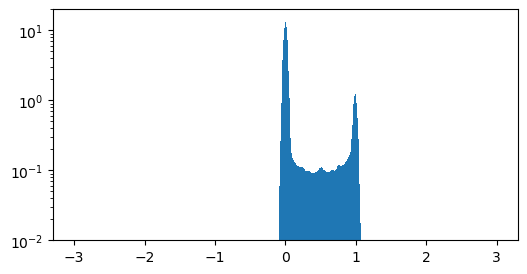


Original cINN generated images
min: -256.6009, median: 0.0084, max: 1725.4885
mean: 0.1232, std: 1.3202
x<0:40.14 %, 0<=x<=1: 57.01 %, x>1:2.85 %


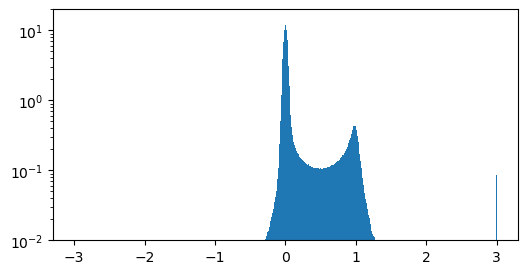


Lazy Augmentation generated images
min: -1512.4041, median: 0.0083, max: 835.2802
mean: 0.1208, std: 1.0247
x<0:40.22 %, 0<=x<=1: 56.98 %, x>1:2.81 %


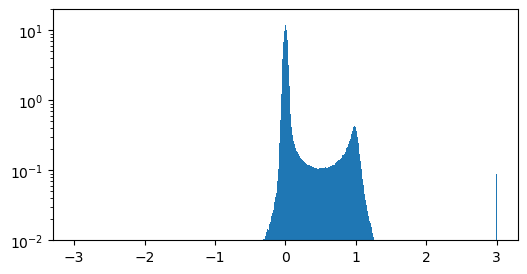


Augmented (one domain) generated images
min: -1710.9441, median: 0.0035, max: 4542.9546
mean: 0.0529, std: 5.2605
x<0:45.95 %, 0<=x<=1: 50.98 %, x>1:3.07 %


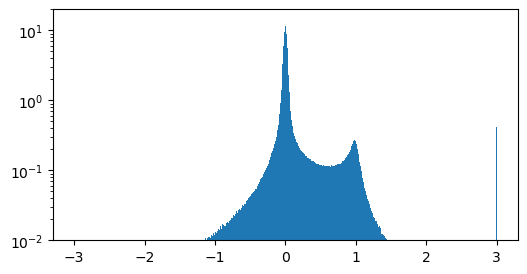


Augmented generated images
min: -352.4343, median: 0.0052, max: 5884.3896
mean: 0.0707, std: 5.0490
x<0:44.40 %, 0<=x<=1: 52.95 %, x>1:2.65 %


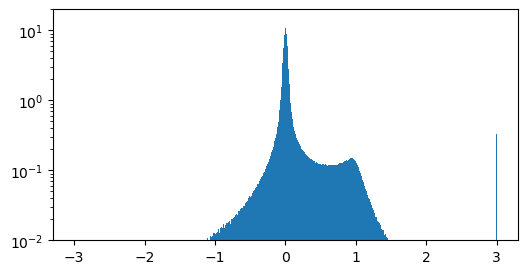


Normalized generated images
min: -859.9517, median: 0.1308, max: 13385.3906
mean: 0.1988, std: 12.0330
x<0:0.45 %, 0<=x<=1: 99.15 %, x>1:0.41 %


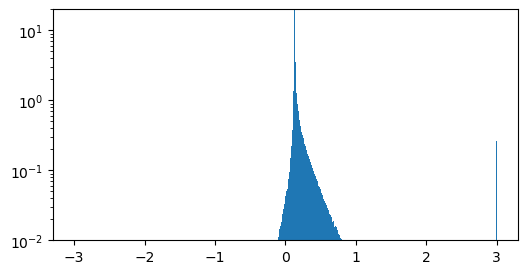


One Domain generated images
min: -6641.0220, median: 0.0002, max: 80118.4766
mean: 0.4559, std: 74.1311
x<0:34.33 %, 0<=x<=1: 64.18 %, x>1:1.49 %


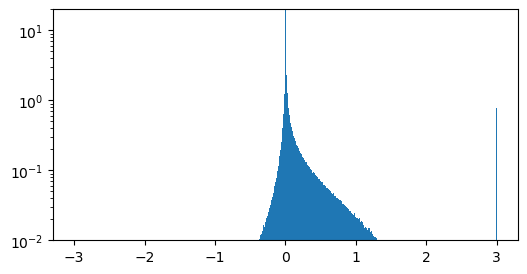

In [23]:
run_data_test(RotatedMNIST._unnormalize(laug_train_data), "Lazy augmented train data")
run_data_test(og_images, "Original cINN generated images")
run_data_test(laug_images, "Lazy Augmentation generated images")
run_data_test(aug_one_images, "Augmented (one domain) generated images")
run_data_test(augm_images, "Augmented generated images")
run_data_test(norm_images, "Normalized generated images")
run_data_test(oned_images, "One Domain generated images")